In [4]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pickle

from scipy import stats

sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

from os import walk

import copy
from scipy.stats import rankdata

In [8]:
nCMs = 9

from functools import lru_cache

def grab_traces(name="baseline", verbose=False):
    files_found = 0
    all_traces = []
    for i, (dirpath, dirnames, filenames) in enumerate(walk(f"cm_traces/{name}")):
        for f in filenames:
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f:
                
                if name == "additive" and "_base.txt" in f:
                    continue
                    
                    
                if "default" in f:
                    if name == "additive":
                        trace = 100*(np.loadtxt(dirpath+"/"+f))
                    else:
                        trace = 100*(1-np.loadtxt(dirpath+"/"+f))
                    
                    default_res = trace
                    print("Found default results.")
        
        
        for f in filenames:
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f and "default" not in f:
                
                if name == "additive" and "_base.txt" in f:
                    continue
                    
                if name == "additive":
                    trace = 100*(np.loadtxt(dirpath+"/"+f))
                else:
                    trace = 100*(1-np.loadtxt(dirpath+"/"+f))
                    
                nS, f_nCMs = trace.shape
                if f_nCMs > nCMs:
                    trace = trace[:, :nCMs]
                elif f_nCMs < nCMs:
                    leaveout_num = int(f[-5])
                    full_trace = np.zeros((nS, nCMs))
                    full_trace[:, :leaveout_num] = trace[:, :leaveout_num]
                    full_trace[:, leaveout_num] = default_res[:, leaveout_num]
                    full_trace[:, (leaveout_num+1):] = trace[:, leaveout_num:]
                    trace = full_trace
            
                all_traces.append(copy.deepcopy(trace))
                files_found += 1

                if verbose:
                    print(f"Importing {f}")
                    
    print(f"Found {files_found} tests")
    return default_res, all_traces

derived_features = [
 ("Mask Wearing", [1-1]),
 ("Symptomatic Testing", [2-1]),
 ("Gatherings <1000", [3-1]),
 ("Gatherings <100", [3-1, 4-1]),
 ("Gatherings <10", [3-1, 4-1, 5-1]),
 ("Some Businesses Suspended", [6-1]),
 ("Most Businesses Suspended", [6-1, 7-1]),
 ("School Closure", [8-1]),
 ("Stay Home Order", [9-1]),  
 ]

def trace_to_results(trace, additive=False):
    testing = 1
    some_bus = 5
    most_bus = 6
    schools = 7
    stay_home = 8
    
    nS, nCMs = trace.shape
    med = np.median(trace, axis=0)
    ranks = rankdata(med)
    schools_conc = (ranks[schools] == 9)
    test_conc = (np.sum(trace[:, testing] > 1)/nS > 0.9)
    
    stay_home_conc = med[stay_home] < 20
    
    business_conc = (med[some_bus] > (2/3) * med[most_bus])
    
    return np.array([schools_conc, test_conc, stay_home_conc, business_conc])

def trace_to_ranks(trace, additive=False, combined=True): 
    nS, nCMs = trace.shape
    
    if combined:
        derived_samples = np.zeros((nS, len(derived_features)))
        if not additive:
            res = -trace/100 + 1
            for f_i, (f, prodrows) in enumerate(derived_features):
                samples = np.ones(nS)
                for r in prodrows:
                    samples = samples * res[:, r] 
                derived_samples[:, f_i] = samples

            res = derived_samples
            res = 100*(1-res)
        else:
            for f_i, (f, prodrows) in enumerate(derived_features):
                samples = np.zeros(nS)
                for r in prodrows:
                    samples += res[:, r] 
                derived_samples[:, f_i] = samples

            res = derived_samples
    else:
        res = trace
    
    med = np.median(res, axis=0)
    ranks = rankdata(med)
    return ranks

In [9]:
to_plot = ["additive", "baseline", "noisy-r7", "diff_effects", "ICL-Variant", "icl_close", "nonoise"]

In [10]:
to_plot = ["additive", "baseline", "noisy-r7", "diff_effects"]
for p in to_plot:
    default_res, all_traces = grab_traces(p)
    def_results = trace_to_results(default_res)
    print(f"{p}: {def_results}")
    
    rs = np.zeros(4)
    for t in all_traces:
        rs += trace_to_results(t)
    rs = rs /len(all_traces)
    print(f"in all: {rs*100}")

Found default results.
Found 38 tests
additive: [ True False  True  True]
in all: [100.          10.52631579 100.         100.        ]
Found default results.
Found 39 tests
baseline: [ True  True  True  True]
in all: [100.          94.87179487 100.         100.        ]
Found default results.
Found 43 tests
noisy-r7: [ True  True  True  True]
in all: [100. 100. 100. 100.]
Found default results.
Found 39 tests
diff_effects: [ True  True  True  True]
in all: [100.          89.74358974 100.         100.        ]


In [11]:
to_plot = ["additive", "baseline", "noisy-r7", "diff_effects"]
rs = np.zeros(4)
tt = 0
for p in to_plot:
    default_res, all_traces = grab_traces(p)
    def_results = trace_to_results(default_res)
    for t in all_traces:
        rs += trace_to_results(t)
    tt += len(all_traces)
print(f"in all: {rs*100/tt}")

Found default results.
Found 38 tests
Found default results.
Found 39 tests
Found default results.
Found 43 tests
Found default results.
Found 39 tests
in all: [100.         74.8427673 100.        100.       ]


In [120]:
to_plot = ["additive", "baseline", "noisy-r7", "diff_effects"]
rs = np.zeros(4)
tt = 0
ranks = []
for p in to_plot:
    default_res, all_traces = grab_traces(p, True if p == 0 else 0)
    for t in all_traces:
        ranks.append(trace_to_ranks(t))

Found default results.
Found 38 tests
Found default results.
Found 36 tests
Found default results.
Found 43 tests
Found default results.
Found 39 tests


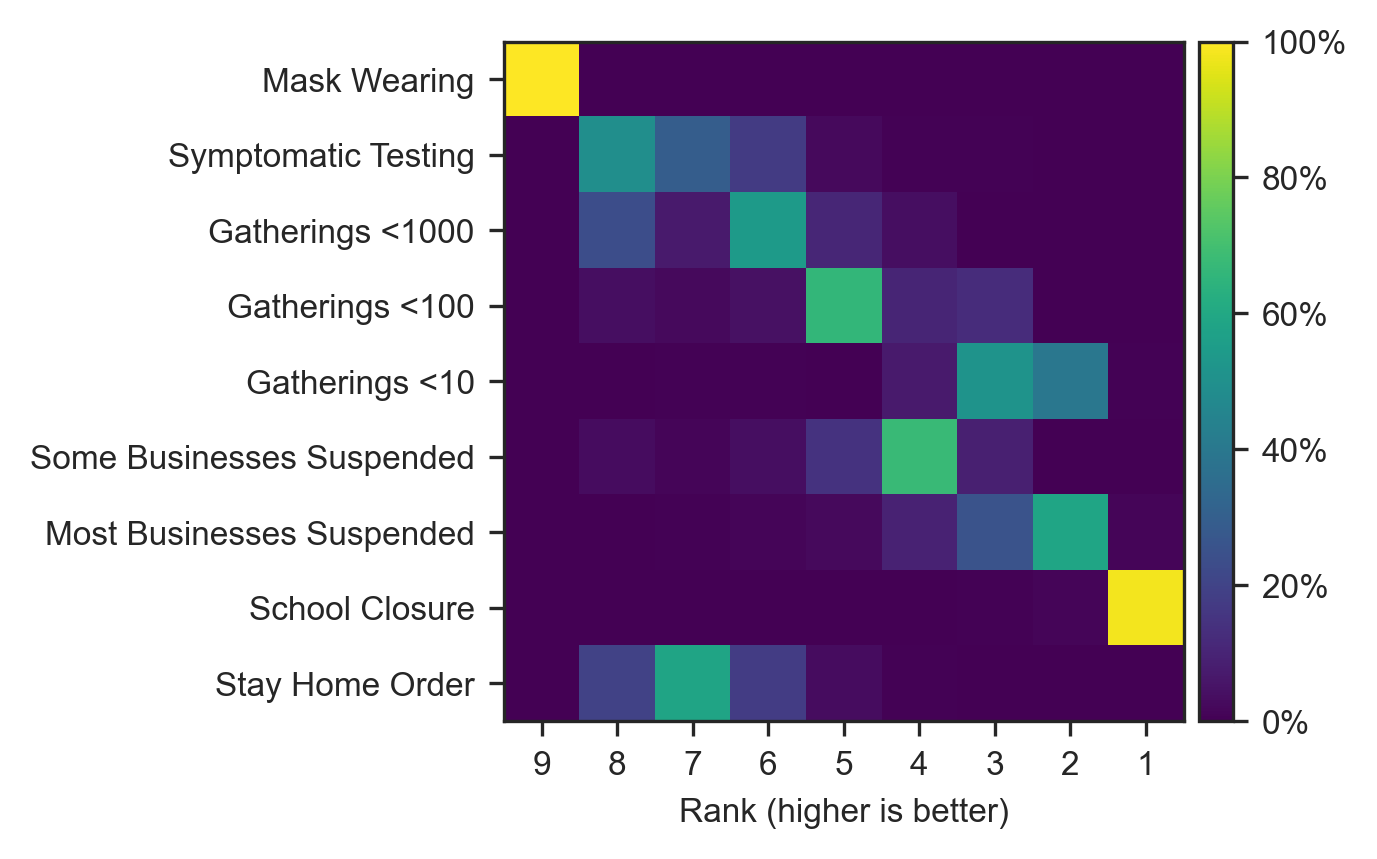

In [121]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import PercentFormatter

ranks = np.array(ranks)
nT, nCMs = ranks.shape

rank_mat = np.zeros((9, 9))

for i in range(9):
    props = []
    for j in range(1, 10):
        props.append(100*np.sum(ranks[:, i] == j) / nT)
    rank_mat[i, :] = np.array(props)

np.savetxt("rank_mat_c.txt", rank_mat)
plt.figure(figsize=(4, 3), dpi=300)
im = plt.imshow(rank_mat, cmap="viridis")
plt.xticks(np.arange(9), np.arange(9, 0, -1), fontsize=8)
plt.xlabel("Rank (higher is better)", fontsize=8)
plt.yticks(np.arange(9), [n for n, _ in derived_features], fontsize=8)


ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, format=PercentFormatter())
ax = plt.gca()
ax.tick_params(axis="both", which="major", labelsize=8)